# 機器學習模型洞見發掘指南

機器學習模型常被形容為「黑箱」，因為它們能做出良好的預測，但無法解釋背後的邏輯。此筆記將教您如何從複雜的機器學習模型中提取以下洞察：

1. 哪些特徵最重要？
2. 單一預測中，每個特徵如何影響結果？
3. 每個特徵對模型預測的整體影響是什麼？

## 洞察的價值

這些洞察有多種用途，包括：

1. **除錯**：了解模型模式能幫助識別數據錯誤。
2. **指導特徵工程**：透過特徵重要性指導創建新特徵。
3. **指導數據收集**：了解現有特徵的價值，有助於推斷哪些新特徵最有幫助。
4. **協助人類決策**：洞察往往比預測更有價值。
5. **建立信任**：展示符合一般理解的洞察，有助於建立對模型的信任。

這些技術讓您能夠透明地理解模型運作，從而改進和信任您的機器學習模型。

[參考資料](https://www.infoq.cn/article/xiytqjiic5spsp04adk9)


# 介紹 Permutation Importance

一個基本的問題是：哪些特徵對模型的預測影響最大？

這個概念稱為特徵重要性。

衡量特徵重要性的方法有很多。有些方法回答了上述問題的不同版本，另一些方法則存在已知的缺陷。

在本課程中，我們將專注於Permutation Importance。與大多數其他方法相比，Permutation Importance具有以下優點：

- 計算速度快
- 廣泛使用且易於理解
- 符合我們對特徵重要性衡量標準的期望

## 運作原理

Permutation Importance 的使用方法與您之前見過的模型使用方法不同，很多人初次接觸時會感到困惑。因此，我們將從一個具體的例子開始解釋。

假設我們的數據格式如下：

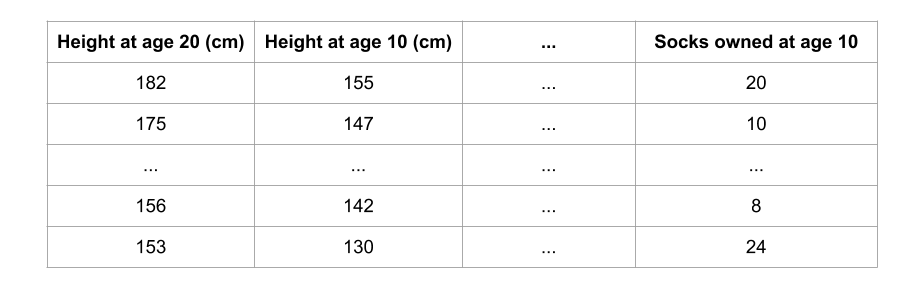

### 問題

我們希望預測一個人在20歲時的身高，使用其10歲時的數據。

我們的數據包括有用的特徵（如10歲時的身高）、預測能力有限的特徵（如擁有的襪子數量），以及其他一些我們在此不關注的特徵。

Permutation Importance 是在模型訓練後計算的。因此，我們不會改變模型或改變給定身高、襪子數量等值的預測結果。

相反，我們會問以下問題：如果我隨機打亂驗證數據中的一列，保持目標值和其他列不變，這會如何影響預測準確性？

### 打亂

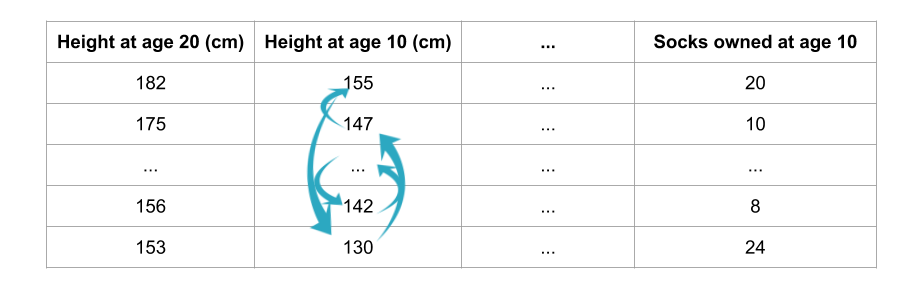

隨機重新排列單列應會導致預測不准確，因為這樣生成的數據不再與真實世界中的觀察相對應。如果我們打亂模型高度依賴的列，預測的準確性會特別受影響。在這個例子中，打亂10歲時的身高會導致糟糕的預測。如果我們打亂擁有的襪子數量，預測結果的影響不會那麼大。

基於這一理解，過程如下：

1. 獲取已訓練的模型。
2. 打亂單列的值，使用生成的數據集進行預測。使用這些預測值和真實目標值計算打亂帶來的**損失函數**變化。這一性能下降衡量的是您剛打亂的變量的重要性。
3. 將數據恢復到原始順序（撤銷打亂的步驟）。然後重複其他欄位的打亂，直到計算出個特徵欄位的重要性。


## example
use a model that predicts whether a soccer/football team will have the "Man of the Game" winner based on the team's statistics. The "Man of the Game" award is given to the best player in the game. Model-building isn't our current focus, so the cell below loads the data and builds a rudimentary model.

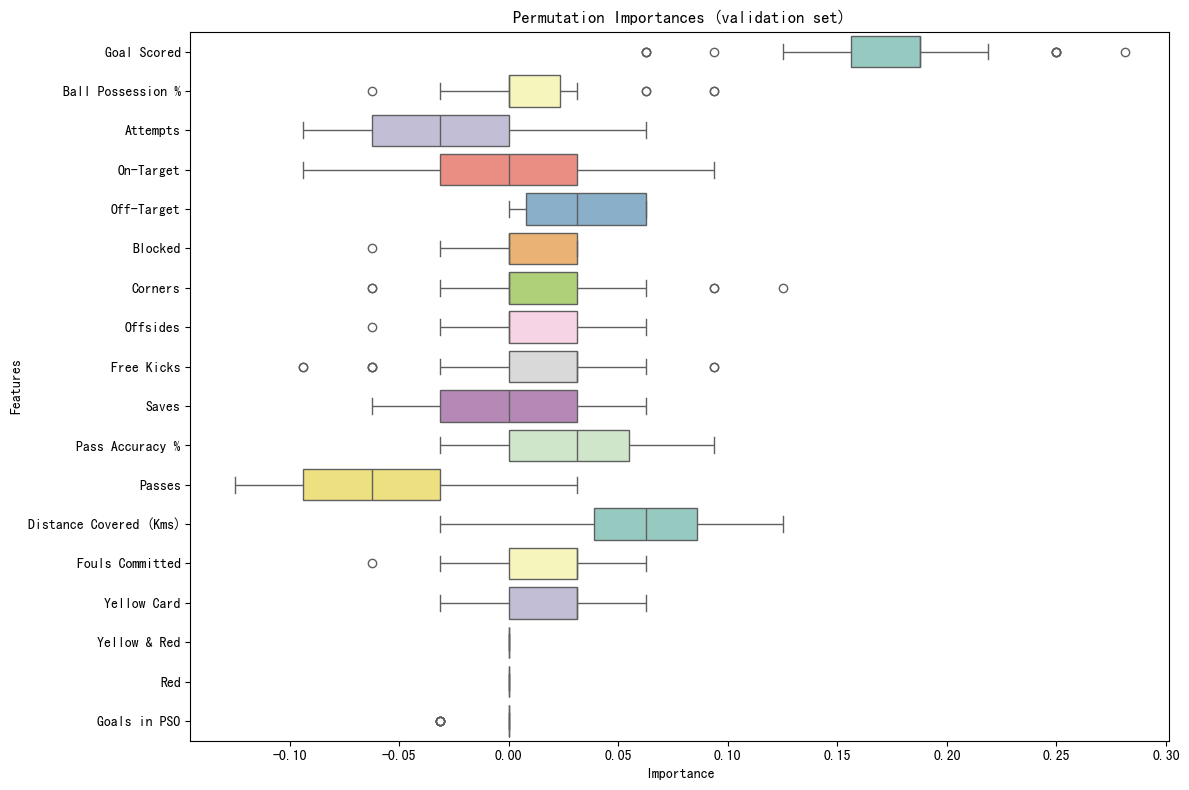

                   Feature      Weight ± Std
0              Goal Scored   0.1729 ± 0.0557
1   Distance Covered (Kms)   0.0594 ± 0.0355
2               Off-Target   0.0333 ± 0.0241
3          Pass Accuracy %   0.0302 ± 0.0273
4              Yellow Card    0.025 ± 0.0272
5          Fouls Committed   0.0177 ± 0.0339
6                  Corners   0.0146 ± 0.0409
7               Free Kicks   0.0104 ± 0.0486
8        Ball Possession %   0.0073 ± 0.0349
9                On-Target    0.0062 ± 0.048
10                   Saves   0.0042 ± 0.0299
11                Offsides   0.0031 ± 0.0272
12                 Blocked    0.001 ± 0.0248
13            Yellow & Red         0.0 ± 0.0
14                     Red         0.0 ± 0.0
15            Goals in PSO  -0.0062 ± 0.0125
16                Attempts   -0.0312 ± 0.047
17                  Passes  -0.0531 ± 0.0362


In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

# get data
data = pd.read_csv('./FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary

feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]

# separate train and validate set
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# setup model and fit
my_model = RandomForestClassifier(n_estimators=100, random_state=0).fit(train_X, train_y)

# Permutation importance
result = permutation_importance(my_model, val_X, val_y,
                                n_repeats=30,  # Number of times to shuffle each feature
                                random_state=0,
                                n_jobs=-1  # Number of jobs to run in parallel
                                )

# Preparing data for plotting
importances = pd.DataFrame(result.importances.T, columns=feature_names)

# Plotting
plt.figure(figsize=(12, 8))
sns.boxplot(data=importances, orient="h", palette="Set3")
plt.title('Permutation Importances (validation set)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# 數據產生表格
importance_means = result.importances_mean
importance_std = result.importances_std

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': importance_means,
    'Std': importance_std
})

importance_df['Weight ± Std'] = importance_df['Weight'].round(4).astype(str) + " ± " + importance_df['Std'].round(4).astype(str)
importance_df = importance_df.sort_values(by='Weight', ascending=False).reset_index(drop=True)

# 輸出類似於圖片中的表格
print(importance_df[['Feature', 'Weight ± Std']])


# 解釋排列重要性

排列重要性圖中的值，越靠近頂端的特徵越重要，而越靠近底部的特徵則越不重要。

每一行中的第一個數字顯示了隨機洗牌後模型性能的下降程度（在此例中，使用「準確性」作為性能指標）。

像數據科學中的大多數事情一樣，從洗牌一列中獲得的準確性能變化存在一定隨機性。我們通過多次洗牌來計算排列重要性的隨機變異性。±後面的數字表示性能在不同洗牌間的變異程度。

有時您會看到排列重要性出現負值。在這些情況下，對於打亂（或噪聲）數據的預測反而比真實數據更準確。這發生在該特徵並不重要（應該有接近於0的重要性），但隨機機會導致對洗牌數據的預測更準確。這在數據集較小時更常見，例如本例中的小數據集，因為運氣/隨機性的影響更大。

在我們的例子中，最重要的特徵是進球數。這看起來是合理的。
其他特徵可能對一些球迷來說有些違背直覺

## 特徵重要性列表

| Feature                  | 中譯名                 | Weight ± Std      | 欄位解釋                                                        |
|--------------------------|------------------------|-------------------|-----------------------------------------------------------------|
| Goal Scored              | 進球數                 | 0.1729 ± 0.0557   | 球隊在比賽中進球的總數，對預測最重要。                         |
| Distance Covered (Kms)   | 跑動距離（公里）       | 0.0594 ± 0.0355   | 球員在比賽中跑動的總距離。                                       |
| Off-Target               | 射偏                   | 0.0333 ± 0.0241   | 球隊射門但未射正的次數。                                         |
| Pass Accuracy %          | 傳球準確率             | 0.0302 ± 0.0273   | 球隊成功傳球的比例。                                             |
| Yellow Card              | 黃牌                   | 0.025 ± 0.0272    | 球員在比賽中獲得的黃牌數。                                       |
| Fouls Committed          | 犯規                   | 0.0177 ± 0.0339   | 球隊在比賽中犯規的次數。                                         |
| Corners                  | 角球                   | 0.0146 ± 0.0409   | 球隊獲得的角球數。                                               |
| Free Kicks               | 任意球                 | 0.0104 ± 0.0486   | 球隊獲得的任意球次數。                                           |
| Ball Possession %        | 控球率                 | 0.0073 ± 0.0349   | 球隊在比賽中控制球的時間比例。                                   |
| On-Target                | 射正                   | 0.0062 ± 0.048    | 球隊射門且射正的次數。                                           |
| Saves                    | 撲救                   | 0.0042 ± 0.0299   | 守門員成功撲救的次數。                                           |
| Offsides                 | 越位                   | 0.0031 ± 0.0272   | 球隊在比賽中被判越位的次數。                                     |
| Blocked                  | 封堵                   | 0.001 ± 0.0248    | 球隊的射門被對方球員封堵的次數。                                 |
| Yellow & Red             | 紅黃牌                 | 0.0 ± 0.0         | 球員在比賽中同時獲得黃牌和紅牌的次數。                           |
| Red                      | 紅牌                   | 0.0 ± 0.0         | 球員在比賽中獲得的紅牌數。                                       |
| Goals in PSO             | 點球大戰進球數         | -0.0062 ± 0.0125  | 球隊在點球大戰中的進球數。                                       |
| Attempts                 | 射門次數               | -0.0312 ± 0.047   | 球隊的總射門次數。                                               |
| Passes                   | 傳球次數               | -0.0531 ± 0.0362  | 球隊在比賽中的總傳球次數。                                       |
